# Distinct element estimation using k-th min 

In the lecture, we studied the algorithm named Idealized $F_0$ estimation (slide 19). The algorithm uses a random hash function to map elements from the stream to float values between 0 and 1. Ultimately, it maintains the smallest hash value $V$ and outputs ${1\over V}-1$ as the estimate $\tilde{F}_0$ for the number of distinct elements.

This algorithm uses the idea that the expected value of the smallest hash value is $1\over F_0+1$, where $F_0$ is the number of distinct elements. In fact, we can generally use the $k$-th smallest hash value $V_k$ for $k=1,2,\dots$. We will use the results from exercise 4 to conduct experiments to see how different $k$ values affect the accuracy of your estimate.

[Optional]: Let m be the length of the stream. You can maintaining the k-th smallest element in an unsorted list in time $O(m\log k)$ using min heap, see https://docs.python.org/3/library/heapq.html. 

In [77]:
# Import packages needed.
import random, math
import numpy as np
import matplotlib.pyplot as plt

To test the effect of k, we must first implement a function that takes a data sequence, hash each element to a value between 0 and 1, and returns the k-th smallest hash value. Python has a built-in hash function hash() that takes any hashable object and returns an integer hash. To convert a hash value to a float, use modular the hash with a large int and divide by it, for instance, $MAXINT=2^{63}-1$.

In [78]:
import sys
MAXINT = sys.maxsize

In [79]:
def kth_smallest_hash_value(input_list, k):
# Write your code here
    hashes = []
    for i in input_list:
        hashfloat = hash(i) % MAXINT / MAXINT
        hashes.append(hashfloat)
    hashes.sort()
    return hashes[k-1]

Now let us test k values between 1 to 10. For each k, we will generate a list of 1000 random **strings** using ``str(random.uniform(0,100))``, and estimate its cardinality via the returned value from the function ``kth_smallest_hash_value`` you implemented. For each k, repeat this process 100 times and record the average and std of the estimates. Finally, generate a plot with error bars to show the relation between estimates and k values. Note that the std for small k can be very large, so you may need to set plt.ylim(-1000, 10000) to cap the y-axis for better visualization.

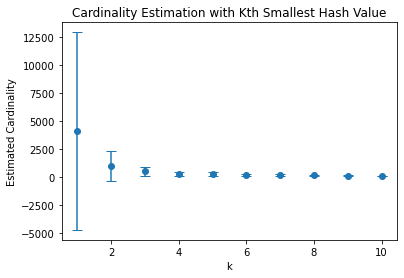

In [80]:
# Write your code here
r = [1,2,3,4,5,6,7,8,9,10]
avg_std = np.zeros((10,2))
for k in r:
    cardiset = np.array([])
    for i in range (100):
        str_list = [str(random.uniform(0, 100)) for _ in range(1000)]
        v1 = kth_smallest_hash_value(str_list, k)
        cardi = 1/v1 -1 #F0
        cardiset = np.append(cardiset,cardi)
    avg_std[k-1][0] = np.mean(cardiset)
    avg_std[k-1][1] = np.std(cardiset)
avg = list(avg_std[i][0] for i in range(10))
std = list(avg_std[i][1] for i in range(10))

plt.errorbar(r, avg, yerr=std, fmt='o', capsize=5)
plt.title('Cardinality Estimation with Kth Smallest Hash Value')
plt.xlabel('k')
plt.ylabel('Estimated Cardinality')
plt.show()

       

## The median trick useful technique (slide 13)

Please implement the function ``median_trick`` below. 

In [133]:
def median_trick(generator, expectation, var, eps, delta):
    '''
    Input:
        generator - a function that generates one sample from a distribution when being called.
        expectation - Expectation of the distribution
        var - Variance of the distribution
        eps - epsilon (accuracy parameter) as defined in slide 13
        delta - delta (confidence parameter) as defined in slide 13
    Output:
        estimated value Q
    '''
    # Write your code here
    t = int(math.ceil(math.log(1/delta, 2)))
    k = int(math.ceil(var/((eps*expectation)**2)))
    sample = np.zeros((t,k))
    for i in range(t):
        val = 0
        for j in range(k):
            sample[i][j]= generator()
    samplesum = np.sum(sample, axis=1)
    median = np.median(samplesum/k)
    return median * (1 + eps) - expectation * eps



Now we want to test the function with the following idea. Assume Q=2. The unbiased estimator, X of Q, generates estimates that follow a normal distribution with variance equal to 1. The generator for X is already given below as ``normal_generator``. Please generate two plots below. 

- Set eps=0.1, and test how the delta affects the estimates. Range delta in [1e-6, 1e-4, 1e-3, 0.01, 0.1]; repeat the estimation 100 times for each delta value. Generate a plot with std as error bars to show how the average estimates change as the delta changes.

- Set delta=0.1, and test how the epsilon affects the estimates. Range epsilon in [0.01, 0.02, 0.05, 0.1, 0.2]; repeat the estimation 100 times for each epsilon value. Generate a plot with std as error bars to show how the average estimates change as the epsilon changes.

In [134]:
# Don't change
def normal_generator():
    return np.random.normal(2,1)

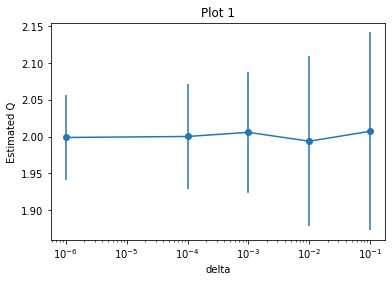

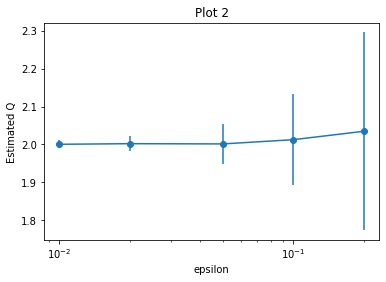

In [149]:
# Write your code here
def plt1(eps=0.1, delt=[1e-6, 1e-4, 1e-3, 0.01, 0.1]):
    Q_avg = []
    Q_std = []
    for d in delt:
        Qset = []
        for _ in range(100):
            Qi = median_trick(normal_generator, 2, 1, eps, d)
            Qset.append(Qi)
        Q_avg.append(np.mean(Qset))
        Q_std.append(np.std(Qset))
    plt.errorbar(delt, Q_avg, yerr=Q_std, fmt='o-')
    plt.xscale('log')
    plt.title('Plot 1')
    plt.xlabel('delta')
    plt.ylabel('Estimated Q')
    plt.show()


def plt2 (delta=0.1,epsl = [0.01, 0.02, 0.05, 0.1, 0.2]):
    Q_avg = np.zeros(5)
    Q_std = np.zeros(5)
    for m in range(5):
        Qset = np.array([])
        for i in range(100):
            s = normal_generator
            Qi = median_trick(s, 2, 1, epsl[m], delta)
            Qset = np.append(Qset,Qi)
        Q_avg[m] = np.mean(Qset)
        Q_std[m] = np.std(Qset)
    plt.errorbar(epsl, Q_avg, yerr=Q_std,fmt='o-')
    plt.xscale('log')
    plt.title('Plot 2')
    plt.xlabel('epsilon')
    plt.ylabel('Estimated Q')
    plt.show()

plt1()        
plt2()

## Morris Algorithm (slide 45)

Morris algorithm maintains a counter c that, for every element in the stream, itself increments by 1 with probability $1\over 2^c$. In the end, it outputs an estimate as $2^c-1$.

In this section, we will change the base of this counter (slide 51). Instead of using 2 only, we use any base $1+\alpha$. We now increase the counter c with probability $1\over (1+\alpha)^c$. First, let us implement the function ``morris_update_base_alpha`` below. **This function is called whenever we see an element from the stream to update the counter.**

In [155]:
def morris_update_base_alpha(counter, alpha):
    '''
    Input:
        counter - current value of counter c
        alpha - as defined in slide 51 alpha
    Output:
        updated value of counter c
    '''
    p = 1/((1+alpha)**counter)
    if np.random.rand() <= p:
        counter +=1
        return counter
    else:
        return counter
        


Now let us test the function with the edge list file "soc-hamsterster.edges" in the same folder. Reading the file line by line in python can generate a stream of strings. Counting the number of strings/lines in this file tells us the number of edges of this "soc-hamsterster" graph. Let us try different alpha values ranging from 2 to 9. Again, for each alpha, estimate the number of lines in the edge list file using the morris algorithm (the key component of which is ``morris_update_base_alpha``), and repeat this 100 times. Besides, check how many bits are needed to maintain the counter via ``math.ceil(math.log(counter, 2))`` at the end of each estimation. Finally, generate two plots with std as error bars to show 

- How the average estimate changes as the alpha value increases. 
- How the space usage (in bits) changes as the alpha value increases.

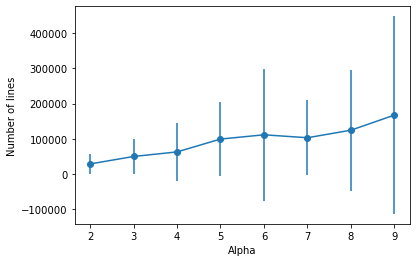

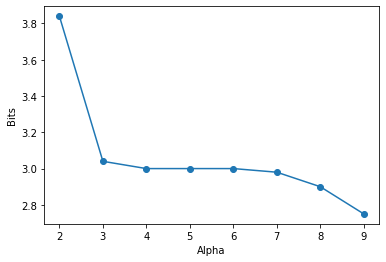

In [160]:
def estimate_edge_count(alpha):
    counter = 0
    space_bits = 0
    with open("soc-hamsterster.edges", "r") as f:
        for line in f:
            counter = morris_update_base_alpha(counter, alpha)
            space_bits = math.ceil(math.log(counter, 2))
    edge = ((1+alpha) ** counter - 1)
    return edge, space_bits

al = [2,3,4,5,6,7,8,9]
avg_edges = np.array([])
std_edges = np.array([])
avg_bits = np.array([])
for i in range(8):    
    edges = np.array([])
    bits = np.array([])
    for r in range(100):
        edge,space_bits = estimate_edge_count(al[i])
        edges =np.append(edges,edge)
        bits = np.append(bits,space_bits)
    avg_edges = np.append(avg_edges,np.mean(edges))    
    std_edges = np.append(std_edges,np.std(edges))    
    avg_bits = np.append(avg_bits,np.mean(bits))    

plt.errorbar(al, avg_edges, yerr=std_edges, fmt='o-')
plt.xlabel('Alpha')
plt.ylabel('Number of lines')
plt.show()    
plt.plot(al, avg_bits, 'o-')
plt.xlabel('Alpha')
plt.ylabel('Bits')
plt.show()